In [179]:
import os
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/notebooks/maki/high-resolution-AMT-with-transformer/pytorch')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torchlibrosa.stft import Spectrogram, LogmelFilterBank,STFT,magphase # use 'magphase' to extract phase informatinon with magnitude
# ref: https://github.com/qiuqiangkong/torchlibrosa
from pytorch_utils import move_data_to_device
from transformer_encoder import TransformerEncoder
from transformer_encoder.utils import PositionalEncoding
from data_generator import MaestroDataset, Sampler
from utilities import int16_to_float32
import IPython.display as ipd
import librosa
import librosa.display

In [132]:
# Config
sample_rate = 16000
window_size = 2048
frames_per_second = 100
hop_size = sample_rate // frames_per_second
mel_bins = 229
fmin = 30
fmax = sample_rate // 2
segment_seconds = 10

window = 'hann'
center = True
pad_mode = 'reflect'
ref = 1.0
amin = 1e-10
top_db = None
max_note_shift=0
augmentor = None

midfeat = 1792
momentum = 0.01

sample_rate = 16000
classes_num = 88    # Number of notes of piano
begin_note = 21     # MIDI note of A0, the lowest note of a piano.
segment_seconds = 10.	# Training segment duration
hop_seconds = 1.
frames_per_second = 100
velocity_scale = 128
batch_size = 16
mini_data = False

workspace = "/notebooks/maki/high-resolution-AMT-with-transformer/workspaces"
hdf5s_dir = os.path.join(workspace, 'hdf5s', 'maestro')

In [167]:
# 音声データの抽出
train_dataset = MaestroDataset(hdf5s_dir=hdf5s_dir, 
    segment_seconds=segment_seconds, frames_per_second=frames_per_second, 
    max_note_shift=max_note_shift, augmentor=augmentor)
meta= [ '2004',  'MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_10_Track10_wav.h5', 150.0]
data = train_dataset.__getitem__(meta)
wav = data["waveform"].reshape([1,-1])
wav = torch.from_numpy(wav)

In [417]:
# スペクトログラム作成用インスタンス
spectrogram_extractor = Spectrogram(n_fft=window_size,
            hop_length=hop_size, win_length=window_size, window=window,
            center=center, pad_mode=pad_mode, freeze_parameters=True)

# logmel変換用インスタンス
logmel_extractor = LogmelFilterBank(sr=sample_rate,
            n_fft=window_size, n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref,
            amin=amin, top_db=top_db, freeze_parameters=True)

# 実際に作成
spectrogram = spectrogram_extractor(wav)
logmel = logmel_extractor(spectrogram)
logmel = logmel.to('cpu').detach().numpy().reshape([1001, 229])
spectrogram = spectrogram.to('cpu').detach().numpy() #(1,1,1001,1025)
DB = librosa.amplitude_to_db(spectrogram, ref=np.max) # (1,1,1001,1025)
DB = np.squeeze(DB, 0) # (1,1001,1025)
DB = np.squeeze(DB, 0) # (1001, 1025)

torch.Size([1, 1, 1001, 1025])


In [418]:
# 位相spec
pt_stft_extractor = STFT(n_fft=window_size, hop_length=hop_size,
    win_length=window_size, window=window, center=center, pad_mode=pad_mode,
    freeze_parameters=True)
(pt_stft_real, pt_stft_imag) = pt_stft_extractor.forward(wav)
(pt_stft_mag, cos, sin) = magphase(pt_stft_real, pt_stft_imag)
#phase = torch.atan2(pt_stft_real, pt_stft_imag) # (1,1,1001,1025)
phase = torch.atan2(pt_stft_imag, pt_stft_real) # (1,1,1001,1025)  ***atan2の引数は第一：y軸(imaginary part) 第二：x軸(real part)

In [405]:
# 横方向で微分
kernel = torch.FloatTensor([-1, 1, 0])
kernel = kernel.expand(1, 1, 1, 3)
phase = phase.transpose(3,2)
IF = F.conv2d(phase, kernel2,padding=(0,1))

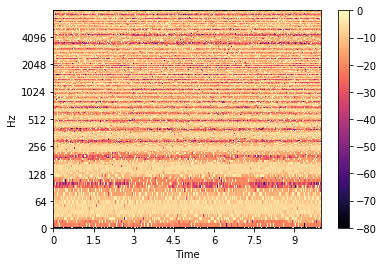

In [408]:
IF_numpy = IF.to('cpu').detach().numpy()
IF_numpy = np.squeeze(IF_numpy, 0)
IF_numpy = np.squeeze(IF_numpy, 0)
#librosa.display.specshow(IF_numpy, sr=sample_rate, hop_length=hop_size, x_axis='time', y_axis='log')
librosa.display.specshow(librosa.amplitude_to_db(IF_numpy, ref=np.max), sr=sample_rate, hop_length=hop_size, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

# 予備のコード

In [170]:
# 音を聞く
ipd.Audio(wav, rate=sample_rate)

In [ ]:
# プロット
# DB = DB.T (時間,周波数)を(周波数,時間)に (0次元目がタテ,1次元目がヨコ)
librosa.display.specshow(DB, sr=sample_rate, hop_length=hop_size, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()